In [1]:
import os
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from glob import glob


# Create custom style dictionary
custom_style = {
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0
}

# Update seaborn's whitegrid style with your custom settings
sns.set_theme(style="whitegrid", rc=custom_style)
sns.set_context("paper", 
                font_scale=2.5,
                rc={
                    "lines.linewidth": 2,
                    "axes.grid": True,
                    "grid.alpha": 0.3,
                    "figure.figsize": (8.5, 6)
                })
from matplotlib import rc

rc('xtick.major', pad=10)
rc('ytick.major', pad=10)
rc('grid', linewidth=1.3)


In [2]:
# Phase and theoretical data exponent according to "4+3 Phases of Compute-Optimal Neural Scaling Laws" by Paquette et al.
def get_phase(alpha, beta):
    if alpha > 0.5:
        if beta < 0.5:
            return 'Ia'
        elif beta < alpha:
            return 'II'
        else:
            return 'III'
    else:
        if beta < 0.5:
            return 'Ib'
        elif alpha > 1 - 1 / np.sqrt(2):
            return 'IVa'
        elif alpha < 0.25:
            return 'Ic'
        else:
            return 'IVb'

def get_data_exponent(alpha, beta):
    phase = get_phase(alpha, beta)
    print(phase)
    
    if phase == 'Ia':
        param_expo = 1/(2*alpha + 1)
    elif phase == 'Ib':
        param_expo = 1/2
    elif phase == 'Ic':
        param_expo = (1-2*(alpha+beta))/(2*(alpha*(2*beta-3)-2*beta+1))
    elif phase == 'II':
        param_expo = (beta/alpha)/(1+beta/alpha)
    elif phase == 'III':
        param_expo = 1/2
    elif phase == 'IVa':
        param_expo = 1/2
    elif phase == 'IVb':
        param_expo = (alpha-beta)/(2*alpha*beta+alpha-2*beta)
    else:
        raise ValueError("Invalid phase")
    data_expo = 1 - param_expo # t ~ c^data_expo
    my_data_expo = data_expo / param_expo
    return my_data_expo

II


/tmp/ipykernel_1075016/2104708351.py:231: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


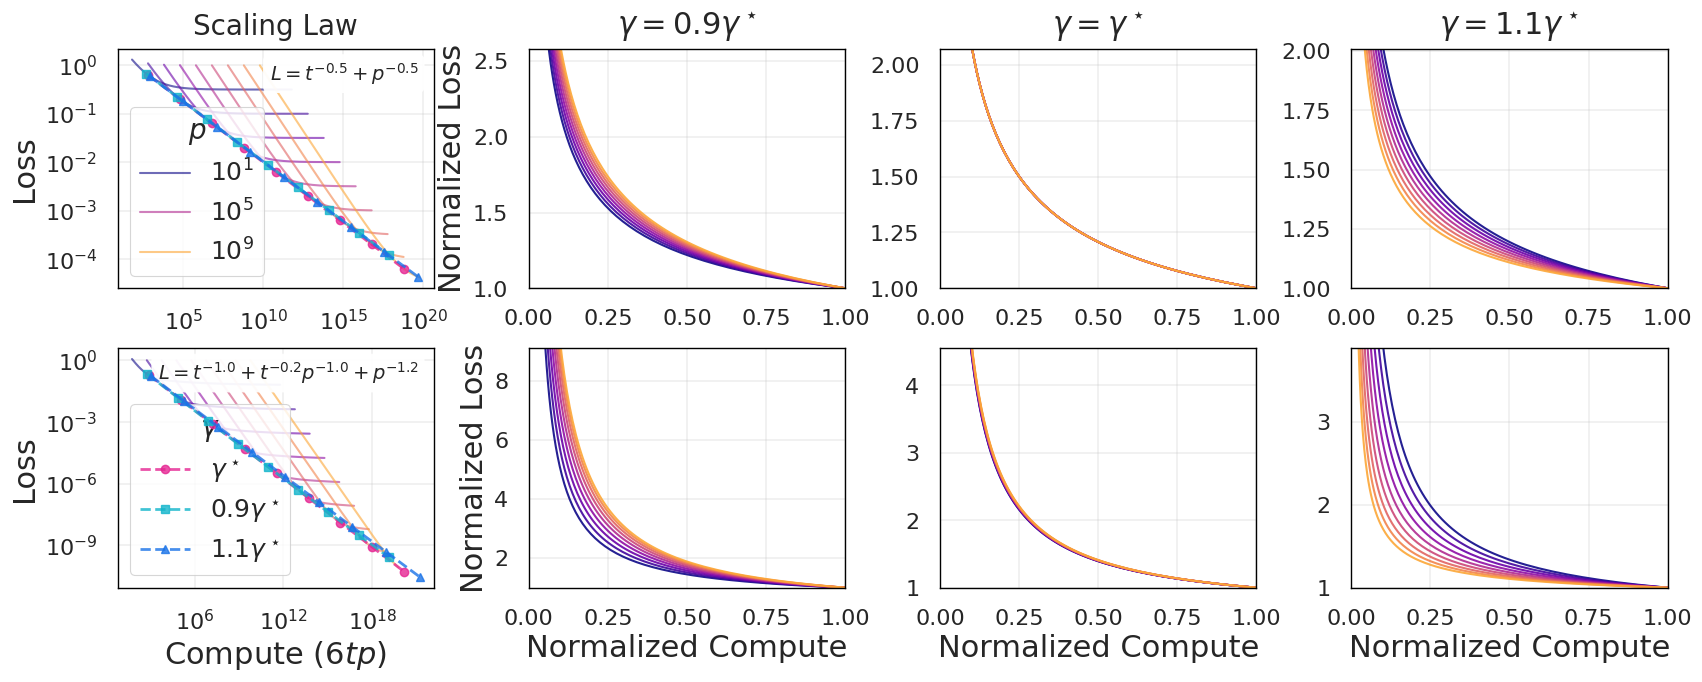

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec

pink_600 = "#e52592"
cyan_600 = "#12b5cb"
blue_600 = "#1a73e8"

# Set parameters for each row
# Row 1 parameters
mu1 = [0.5, 0]  # Token exponents
nu1 = [0, 0.5]  # Parameter exponents
a1 = [1.0, 1.0]   # Coefficients
gamma_opt1 = 1.0  # Optimal data exponent
const1 = 1.0  # Constant for optimal compute

# Row 2 parameters (different power law)
# Correspond to Phase 2 in "4+3 Phases of Compute-Optimal Neural Scaling Laws" by Paquette et al.
a = 0.6 # alpha
b = 0.52 # beta

#      F0,                      Fpp,            Fac,        Kpp
mu2 = [0,                   1+b/a - 1/(2*a), 1 - 1/(2*a), 2 - 1/(2*a)][:3]  # Kpp doesn't matter in this phase
nu2 = [2*a - max(0, 1-2*b), 0,               1          , 0][:3]
a2 = [1.0,                  1.0,             1.0        , 1.0][:3]   

gamma_opt2 = get_data_exponent(a, b)  
const2 = 1  # Different constant

L0 = 0.0    # Baseline loss

# Model sizes (parameters)
P_values = np.logspace(1, 9, 9)  # 10 to 1B parameters
eps = 0.1

t_min = 1
t_max = 1e10

# Create colormap
cmap = plt.cm.plasma

# Update plot settings
plt.rcParams.update({'xtick.labelsize': 16, 'ytick.labelsize': 16})

# Create 2x4 subplot figure (1 scaling law + 3 collapse)
fig = plt.figure(figsize=(20, 7), dpi=100)
gs = GridSpec(2, 4, wspace=0.3, hspace=0.25)

# Function to compute loss from power law
def compute_loss(t, p, mu_vals, nu_vals, a_vals, L0=0):
    """Compute loss as sum of power laws"""
    loss = np.full_like(t, L0, dtype=float)
    for mu_i, nu_i, a_i in zip(mu_vals, nu_vals, a_vals):
        loss += a_i * (t)**(-mu_i) * (p)**(-nu_i)
    return loss

# Function to find optimal compute for a given model
def find_optimal_compute(p, const, gamma):
    """Find optimal compute C* = const * p^gamma"""
    return const * (p ** gamma)

# Generate colors based on parameter values
Pmin = P_values.min()
Pmax = P_values.max()
colors = 0.8 * (np.log(P_values) - np.log(Pmin)) / (np.log(Pmax) - np.log(Pmin))

# Store row parameters
row_params = [
    (mu1, nu1, a1, gamma_opt1, const1),
    (mu2, nu2, a2, gamma_opt2, const2)
]

# Column titles
column_titles = ['Scaling Law', rf'$\gamma = {1-eps}\gamma^\star$', rf'$\gamma = \gamma^\star$', rf'$\gamma = {1+eps}\gamma^\star$']

# For each row
for row, (mu_row, nu_row, a_row, gamma_opt_row, const_row) in enumerate(row_params):
    
    # First column: Scaling law
    ax = plt.subplot(gs[row, 0])
    
    # Add title only for first row
    if row == 0:
        ax.set_title(column_titles[0], fontsize=20, pad=10)
    def format_term(mu, nu):
        if mu == 0 and nu == 0:
            return '1'
        elif mu == 0:
            return rf'p^{{-{nu:.1f}}}'
        elif nu == 0:
            return rf't^{{-{mu:.1f}}}'
        else:
            return rf't^{{-{mu:.1f}}} p^{{-{nu:.1f}}}'
    
    # Sort terms by decreasing mu
    sorted_indices = sorted(range(len(mu_row)), key=lambda i: mu_row[i], reverse=True)
    
    # Format terms and group every 2 terms per line
    terms = [format_term(mu_row[i], nu_row[i]) for i in sorted_indices]
    
    # Split terms into lines of 2
    term_lines = []
    for i in range(0, len(terms), 4):
        if i + 1 < len(terms):
            term_lines.append(' + '.join(terms[i:i+4]))
        else:
            term_lines.append(terms[i])
    
    loss_expr = r'$L = ' + ' +\\\\'.join(term_lines) + '$'
    ax.text(0.95, 0.95, loss_expr, transform=ax.transAxes, fontsize=14, 
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.95))

    
    # Plot scaling laws for different model sizes
    # First, collect all optimal points for lines
    opt_computes = []
    opt_losses = []
    opt_computes_low = []
    opt_losses_low = []
    opt_computes_high = []
    opt_losses_high = []
    
    for i, (p, color_val) in enumerate(zip(P_values, colors)):
        # Use the optimal gamma for this row
        t_opt = find_optimal_compute(p, const_row, gamma_opt_row)
        
        # Generate token values (log-spaced)
        t = np.geomspace(t_min, t_max, 200)
        compute = 6 * t * p
        compute_opt = 6 * t_opt * p
        
        # Compute losses
        losses = compute_loss(t, p, mu_row, nu_row, a_row, L0)
        
        # Plot - only label a few curves for clarity
        if i in [0, len(P_values)//2, len(P_values)-1] and row == 0:
            label = f'$10^{{{int(np.log10(p))}}}$'
        else:
            label = None
        ax.plot(compute, losses, color=cmap(color_val), lw=1.5, label=label, alpha=0.6)
        
        # Collect optimal points
        opt_loss = compute_loss(np.array([t_opt]), p, mu_row, nu_row, a_row, L0)[0]
        opt_computes.append(compute_opt)
        opt_losses.append(opt_loss)
        
        # Collect alternative optimal points with different gammas
        # Using 0.8 * gamma_opt
        t_opt_low = find_optimal_compute(p, const_row, (1 - eps) * gamma_opt_row)
        compute_opt_low = 6 * t_opt_low * p
        opt_loss_low = compute_loss(np.array([t_opt_low]), p, mu_row, nu_row, a_row, L0)[0]
        opt_computes_low.append(compute_opt_low)
        opt_losses_low.append(opt_loss_low)
        
        # Using 1.2 * gamma_opt
        t_opt_high = find_optimal_compute(p, const_row, (1 + eps) * gamma_opt_row)
        compute_opt_high = 6 * t_opt_high * p
        opt_loss_high = compute_loss(np.array([t_opt_high]), p, mu_row, nu_row, a_row, L0)[0]
        opt_computes_high.append(compute_opt_high)
        opt_losses_high.append(opt_loss_high)
    
    # Plot lines through optimal points
    if row == 1:
        ax.plot(opt_computes, opt_losses, 'o--', color=pink_600, markersize=6, linewidth=2, zorder=10, alpha=0.8, label=r'$\gamma^\star$')
        ax.plot(opt_computes_low, opt_losses_low, 's--', color=cyan_600, markersize=6, linewidth=2, zorder=10, alpha=0.8, label=rf'${1-eps}\gamma^\star$')
        ax.plot(opt_computes_high, opt_losses_high, '^--', color=blue_600, markersize=6, linewidth=2, zorder=10, alpha=0.8, label=rf'${1+eps}\gamma^\star$')
    else:
        ax.plot(opt_computes, opt_losses, 'o--', color=pink_600, markersize=6, linewidth=2, zorder=10, alpha=0.8)
        ax.plot(opt_computes_low, opt_losses_low, 's--', color=cyan_600, markersize=6, linewidth=2, zorder=10, alpha=0.8)
        ax.plot(opt_computes_high, opt_losses_high, '^--', color=blue_600, markersize=6, linewidth=2, zorder=10, alpha=0.8)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    if row == 1:
        ax.set_xlabel('Compute $(6tp)$', fontsize=22)
    ax.set_ylabel('Loss', fontsize=22)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=18, loc='lower left', title=r'$p$' if row == 0 else r'$\gamma$', title_fontsize=20)
    
    # Columns 1-3: Collapse plots (3 collapse figures)
    gamma_values = [(1 - eps) * gamma_opt_row, 1.0 * gamma_opt_row, (1 + eps) * gamma_opt_row]
    
    for col, gamma in enumerate(gamma_values, 1):
        ax = plt.subplot(gs[row, col])
        
        # Add title only for first row
        if row == 0:
            ax.set_title(column_titles[col], fontsize=22, pad=10)
        
        # Plot collapse for each model size
        max_loss_at_01 = 1.0  # Initialize with minimum possible value
        
        for i, (p, color_val) in enumerate(zip(P_values, colors)):
            # Find optimal t for this gamma
            t_opt = find_optimal_compute(p, const_row, gamma)
            
            # Generate token values around optimal
            t = np.geomspace(t_opt * 0.001, t_opt, 200)
            compute = 6 * t * p
            
            # Compute losses
            losses = compute_loss(t, p, mu_row, nu_row, a_row, L0)
            
            # Find the endpoint (optimal point) for normalization
            opt_idx = np.argmin(losses)
            opt_compute = compute[opt_idx]
            opt_loss = losses[opt_idx]
            
            # Normalize by endpoint
            normalized_compute = compute / opt_compute
            normalized_loss = losses / opt_loss
            
            # Find loss value at x=0.1 for ylim calculation
            idx_01 = np.argmin(np.abs(normalized_compute - 0.1))
            loss_at_01 = normalized_loss[idx_01]
            max_loss_at_01 = max(max_loss_at_01, loss_at_01)
            
            # Plot normalized curves
            ax.plot(normalized_compute, normalized_loss, color=cmap(color_val), lw=1.5, alpha=0.9)
        
        if row == 1:
            ax.set_xlabel('Normalized Compute', fontsize=22)
        if col == 1:
            ax.set_ylabel('Normalized Loss', fontsize=22)
        ax.set_xlim(0, 1)
        ax.set_ylim(1, max_loss_at_01)
        ax.grid(True, alpha=0.3)
        # ax.set_title(f'γ = {gamma:.1f}', fontsize=14)
plt.tight_layout()
# plt.savefig('figures/simulated_power_laws.pdf', bbox_inches='tight')
plt.show()